In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K

Using Theano backend.


## Helper fcns

In [72]:
def LOSOCV(Data,X,y,groups,models):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; 
        acc_all=[]; acc_train=[] #sens and spec for current model and all subject
        f1_test_all=[]; prec_all=[]; rec_all=[]; auprc_all=[]; auroc_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            #f1-score, prec and recall, auprc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                auroc = np.nan

            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            print('\nSubj %d, prec=%.3f, rec=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred)))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all)))
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [4]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

### CNN functions

In [5]:
# useful functions
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))

    return X_train, X_valid


def model_conv(model):
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_eval(X_valid,y_valid):
    fig=plt.figure()
    fig.add_subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    fig.add_subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('accuracy')
    plt.legend(['train','test'],loc='best')

    #performance eval
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_true = np.argmax(y_valid, axis=1)
    y_score = model.predict(X_valid)[:,1]
    
    f1_test=f1_score(y_true,y_pred)
    Prec = precision_score(y_true,y_pred)
    Rec = recall_score(y_true,y_pred)
    precision, recall, _ = precision_recall_curve(y_true,y_score)
    auprc = auc(recall,precision)

    print('f1_test=%.3f, Prec=%.3f, Rec=%.3f, auprc=%.3f'%(f1_test,Prec,Rec,auprc))
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
    print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))

def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    acc = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(acc,axis=0)
    s = np.std(acc,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(5,10):
            print(np.std(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

### Load data

In [6]:
#load feature matrix - TREMOR
# Data = pd.read_csv(os.path.join(features_path,'Datatremor.csv')) #band-pass filter 3-8 Hz
# Data = pd.read_csv(os.path.join(features_path,'Databradykinesia.csv')) #low-pass 3 Hz
Data = pd.read_csv(os.path.join(features_path,'Data.csv')) #only HP filter
print(Data.shape)
Data.head(2)

(28499, 44)


,Unnamed: 0,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.007757,0.010663,0.006639,...,0.001943,3.019358,8.685826,0.000318,0.039815,-0.184625,12.745926,0.632860,0.662610,0.612830
1,1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.007055,0.010101,0.006168,...,0.001101,2.173485,4.459587,0.000191,0.025149,-0.091885,0.860041,0.621925,0.629151,0.538592


In [7]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1047, 1049, 1051])

In [8]:
Data.Location.unique()

array(['dorsal_hand_left', 'dorsal_hand_right'], dtype=object)

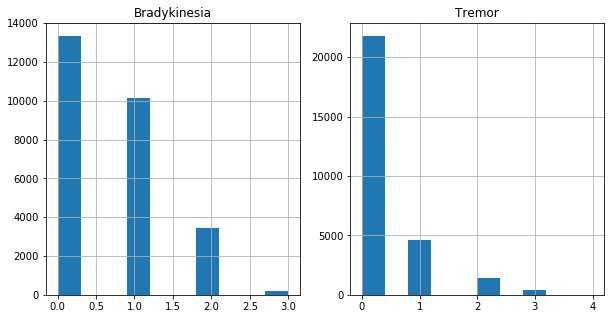

In [9]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

How many instances of symptoms (>0) we have per subject and task

(<matplotlib.text.Text at 0x112b76cc0>, <matplotlib.text.Text at 0x112b52400>)

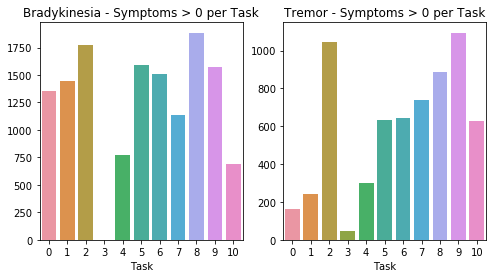

In [10]:
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0))
    TremorP.append(sum(d['Tremor'] > 0))

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(<matplotlib.text.Text at 0x113c17198>, <matplotlib.text.Text at 0x113a603c8>)

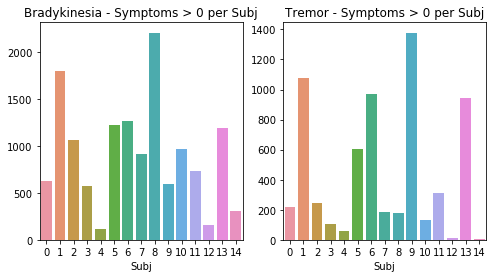

In [11]:
BradP=[]; TremorP=[]
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0))
    TremorP.append(sum(d['Tremor'] > 0))

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')


## Organize target scores into array

In [10]:
symptom = 'Bradykinesia'
# symptom = 'Tremor'

In [11]:
#rows with symptoms 
indp = ((Data[symptom]>0))
indp = indp.values

In [12]:
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

Rows w Bradykinesia 13734/28499 = 0.48


# PCA on features to visualize subjects with symptom


In [16]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [14]:
#standardize features
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)
print(X.shape)

(28499, 37)


total explained variance ratio (first 10 components): 0.698
[ 0.25546264  0.11378353  0.07891479  0.05579717  0.04323576  0.03198841
  0.03067557  0.03007572  0.02989394  0.02828488]


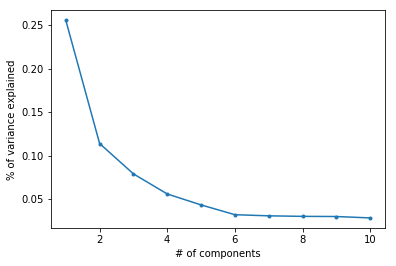

In [15]:
%matplotlib inline
nC = 10
pca = PCA(n_components=nC)
Xpca = pca.fit(X_std).transform(X_std)
# Percentage of variance explained for each components
print('total explained variance ratio (first %d components): %.3f'%(nC, pca.explained_variance_ratio_[0:nC].sum()))
print(pca.explained_variance_ratio_[:10])
ax = plt.plot(range(1,nC+1),pca.explained_variance_ratio_,'.-')
plt.xlabel('# of components')
plt.ylabel('% of variance explained')

In [43]:
Xpca.shape

(28499, 10)

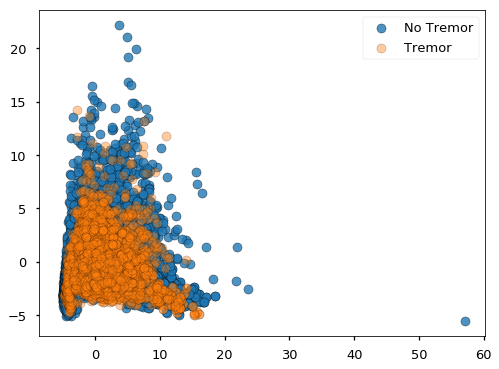

In [44]:
sns.set_context('talk')
fig = plt.figure(figsize=(8,6))
plt.scatter(Xpca[~indp,0],Xpca[~indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.8,label='No '+symptom)
plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label=symptom)
plt.legend()

### PCA on a subject basis

total explained variance ratio (first 10 components): 0.746
total explained variance ratio (first 10 components): 0.721
total explained variance ratio (first 10 components): 0.713
total explained variance ratio (first 10 components): 0.713
total explained variance ratio (first 10 components): 0.738
total explained variance ratio (first 10 components): 0.712
total explained variance ratio (first 10 components): 0.713
total explained variance ratio (first 10 components): 0.710
total explained variance ratio (first 10 components): 0.721
total explained variance ratio (first 10 components): 0.727
total explained variance ratio (first 10 components): 0.722
total explained variance ratio (first 10 components): 0.717
total explained variance ratio (first 10 components): 0.725
total explained variance ratio (first 10 components): 0.697
total explained variance ratio (first 10 components): 0.739


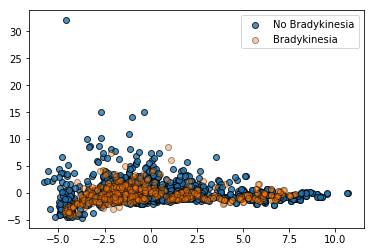

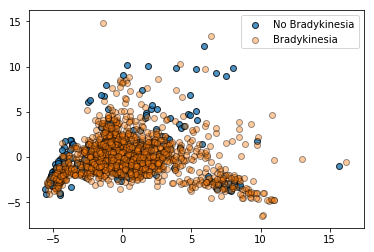

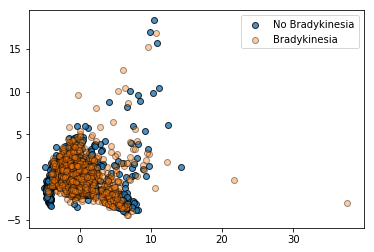

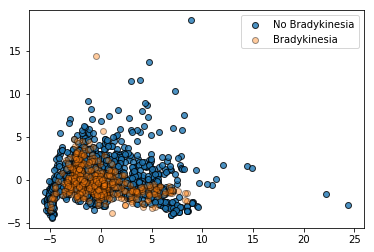

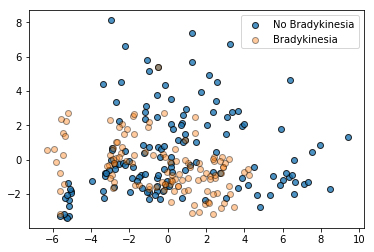

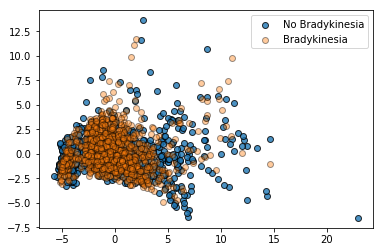

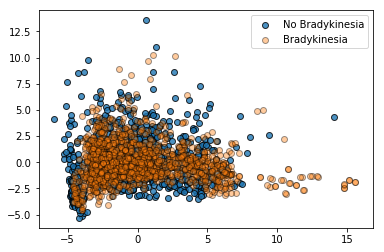

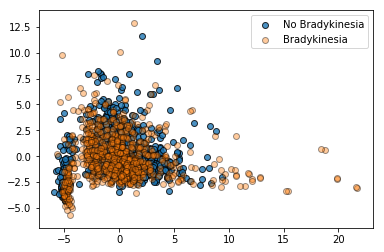

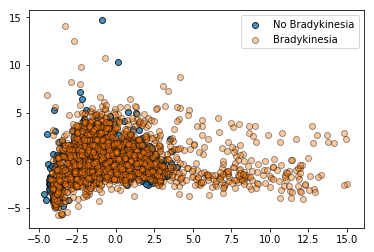

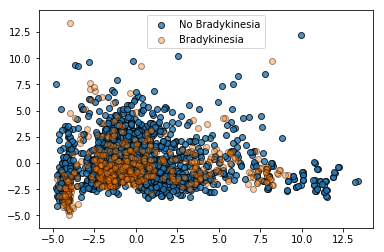

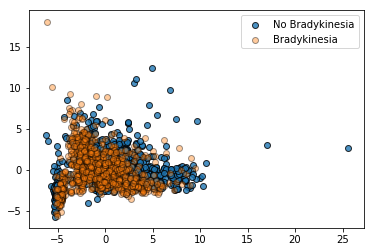

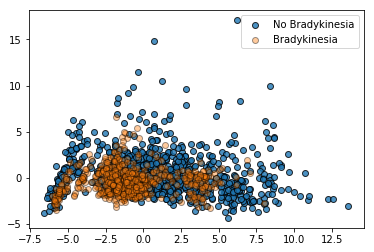

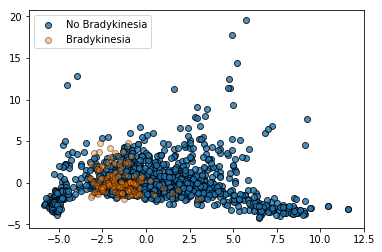

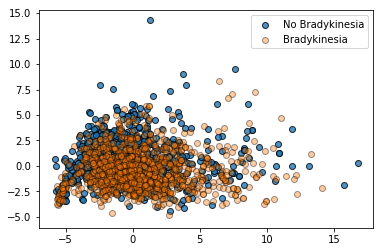

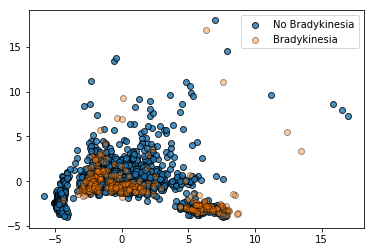

In [31]:
nC = 10

for s in Data.Subject.unique():
    ds = Data.loc[Data.Subject==s] 
    Xs = ds.iloc[:,7:] #features data
    Xs_std = StandardScaler().fit_transform(Xs)
    indp = ((ds[symptom]>0)) #rows with symptoms
    indp = indp.values
    #transform data (PCA)
    pca = PCA(n_components=nC)
    Xpca = pca.fit(Xs_std).transform(Xs_std)
    print('total explained variance ratio (first %d components): %.3f'%(nC, pca.explained_variance_ratio_[0:nC].sum()))
    plt.figure()
    plt.scatter(Xpca[~indp,0],Xpca[~indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.8,label='No '+symptom)
    plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label=symptom)
    plt.legend()


# Fit some classifiers to data using LOSOCV

In [32]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [33]:
#LOSO CV


In [34]:
print(X_std.shape)

(28499, 37)


In [98]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res = LOSOCV(Data,X_std,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 6421/28499 = 0.23
Training Random Forest

Subj 0, prec=0.258, rec=0.142

Subj 1, prec=0.667, rec=0.026

Subj 2, prec=0.464, rec=0.107

Subj 3, prec=0.217, rec=0.533

Subj 4, prec=0.457, rec=0.267

Subj 5, prec=0.345, rec=0.067

Subj 6, prec=0.601, rec=0.214

Subj 7, prec=0.731, rec=0.475

Subj 8, prec=0.435, rec=0.114

Subj 9, prec=0.963, rec=0.248

Subj 10, prec=0.550, rec=0.538

Subj 11, prec=0.048, rec=0.010

Subj 12, prec=0.000, rec=0.000

Subj 13, prec=0.810, rec=0.468

Subj 14, prec=0.029, rec=0.167
f1_test=0.256+/-0.196, prec=0.438+/-0.282, rec=0.225+/-0.185, auprc=0.398+/-0.258
Rows w Bradykinesia 13734/28499 = 0.48
Training Random Forest

Subj 0, prec=0.378, rec=0.387

Subj 1, prec=0.914, rec=0.530

Subj 2, prec=0.713, rec=0.651

Subj 3, prec=0.485, rec=0.920

Subj 4, prec=0.541, rec=0.555

Subj 5, prec=0.706, rec=0.522

Subj 6, prec=0.644, rec=0.541

Subj 7, prec=0.656, rec=0.707

Subj 8, prec=0.855, rec=0.434

Subj 9, prec=0.313, rec=0.500

Subj 10, prec=0.658,

## Personal models - Leave one visit out

In [89]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))


Subject 1004
Training Random Forest

Subj 0, prec=0.000, rec=0.000

Subj 1, prec=0.806, rec=0.213

Subj 2, prec=0.161, rec=0.104

Subj 3, prec=0.184, rec=0.292

Subj 4, prec=0.800, rec=0.615

Subj 5, prec=0.333, rec=0.577

Subj 6, prec=0.625, rec=0.492

Subj 7, prec=0.711, rec=0.621
f1_test=0.378+/-0.236, prec=0.452+/-0.299, rec=0.364+/-0.229, auprc=0.527+/-0.265
Subject 1016
Training Random Forest

Subj 0, prec=0.915, rec=0.985

Subj 1, prec=0.873, rec=0.992

Subj 2, prec=0.878, rec=0.987

Subj 3, prec=0.934, rec=0.978

Subj 4, prec=0.861, rec=1.000

Subj 5, prec=0.910, rec=0.956

Subj 6, prec=0.869, rec=0.911
f1_test=0.930+/-0.020, prec=0.891+/-0.026, rec=0.973+/-0.028, auprc=0.950+/-0.040
Subject 1018
Training Random Forest

Subj 0, prec=0.815, rec=0.721

Subj 1, prec=0.830, rec=0.993

Subj 2, prec=0.745, rec=0.838

Subj 3, prec=0.878, rec=0.921

Subj 4, prec=0.963, rec=0.829

Subj 5, prec=0.616, rec=0.959

Subj 6, prec=0.671, rec=0.723
f1_test=0.813+/-0.078, prec=0.788+/-0.111, rec

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj 2, prec=0.000, rec=0.000

Subj 3, prec=0.900, rec=0.265


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj 4, prec=0.000, rec=0.000

Subj 5, prec=0.000, rec=0.000

Subj 6, prec=0.000, rec=0.000
f1_test=0.104+/-0.166, prec=0.227+/-0.364, rec=0.067+/-0.108, auprc=0.685+/-0.045
Subject 1049
Training Random Forest

Subj 0, prec=0.851, rec=0.902

Subj 1, prec=0.890, rec=0.885

Subj 2, prec=0.896, rec=0.859

Subj 3, prec=0.930, rec=0.750

Subj 4, prec=0.896, rec=0.896

Subj 5, prec=0.881, rec=0.855

Subj 6, prec=0.548, rec=0.595
f1_test=0.829+/-0.107, prec=0.842+/-0.122, rec=0.820+/-0.103, auprc=0.892+/-0.121
Subject 1051
Training Random Forest

Subj 0, prec=0.938, rec=0.176

Subj 1, prec=0.769, rec=0.435

Subj 2, prec=0.643, rec=0.643

Subj 3, prec=1.000, rec=0.232

Subj 4, prec=0.353, rec=1.000

Subj 5, prec=0.615, rec=0.667

Subj 6, prec=1.000, rec=0.095
f1_test=0.458+/-0.167, prec=0.760+/-0.223, rec=0.464+/-0.301, auprc=0.741+/-0.116


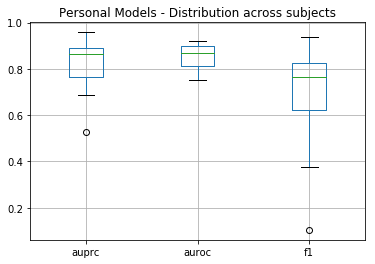

In [95]:
res_all.boxplot()
plt.title('Personal Models - Results across subjects')

In [96]:
res_all.head()

,auprc,auroc,f1,model
1004,0.527017,0.752762,0.377603,Random Forest
1016,0.950087,0.813792,0.929915,Random Forest
1018,0.885302,0.876690,0.813431,Random Forest
1019,0.870977,0.921425,0.683505,Random Forest
1024,0.852822,0.814871,0.755514,Random Forest


## Try with k-fold CV

In [98]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 6421/28499 = 0.23
Random Forest
f1_train=1.000+/-0.000, f1_test=0.556+/-0.008, prec=0.843+/-0.016, rec=0.415+/-0.010, auprc=0.736+/-0.005
[[4294  121]
 [ 743  541]]
XGB
f1_train=0.468+/-0.006, f1_test=0.447+/-0.015, prec=0.758+/-0.010, rec=0.317+/-0.014, auprc=0.637+/-0.005
[[4279  136]
 [ 843  441]]
Rows w Bradykinesia 13734/28499 = 0.48
Random Forest
f1_train=1.000+/-0.000, f1_test=0.758+/-0.005, prec=0.773+/-0.004, rec=0.743+/-0.008, auprc=0.850+/-0.003
[[2338  615]
 [ 731 2015]]
XGB
f1_train=0.721+/-0.002, f1_test=0.703+/-0.009, prec=0.693+/-0.008, rec=0.714+/-0.011, auprc=0.758+/-0.008
[[2040  913]
 [ 823 1923]]


In [109]:
t1=time.time()
for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('\nRows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=True)

print('Elapsed time = %.3f'%(round(time.time()-t1)))


Rows w Tremor 6421/28499 = 0.23
Npos = 5137, Nneg = 5137
Random Forest
f1_train=1.000+/-0.000, f1_test=0.613+/-0.007, prec=0.505+/-0.010, rec=0.781+/-0.010, auprc=0.698+/-0.009
[[3401 1014]
 [ 291  993]]
Npos = 5137, Nneg = 5137
XGB
f1_train=0.784+/-0.004, f1_test=0.570+/-0.010, prec=0.458+/-0.010, rec=0.755+/-0.017, auprc=0.627+/-0.006
[[3259 1156]
 [ 302  982]]

Rows w Bradykinesia 13734/28499 = 0.48
Npos = 10988, Nneg = 10988
Random Forest
f1_train=1.000+/-0.000, f1_test=0.763+/-0.009, prec=0.758+/-0.009, rec=0.767+/-0.010, auprc=0.848+/-0.005
[[2245  708]
 [ 672 2074]]
Npos = 10988, Nneg = 10988
XGB
f1_train=0.735+/-0.001, f1_test=0.707+/-0.009, prec=0.678+/-0.008, rec=0.739+/-0.012, auprc=0.757+/-0.009
[[1941 1012]
 [ 767 1979]]
Elapsed time = 131.000


## CNN on rawdata

In [18]:
# data = pd.read_hdf('../FeatureMatrix/DataRawclips.hdf5')

In [18]:
data = pd.read_hdf('../FeatureMatrix/DataRawcl')

In [12]:
# data = pd.read_hdf('../FeatureMatrix/DataRawClipsUnfiltered.hdf5')

In [19]:
data.head()

,Subject,Visit,Task,Location,Bradykinesia,Tremor,Dyskinesia,acc_xyz,gyr_xyz
0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.00442182590312, -0.0200148763835, -0.01990...","[[2.41092545968, 28.7174792096, 1.80056458381]..."
1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[-0.0607082544856, -0.0905657087803, 0.064953...","[[-54.4136720836, 12.9701686122, 110.688944839..."
2,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.220442267724, 0.152858651212, 0.1146350880...","[[-45.2582589456, 7.66002899214, 38.7884336614..."
3,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[-0.000921648804147, -0.0425384594624, 0.1049...","[[-10.7118333715, -65.6443121996, 15.411612115..."
4,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.055472374389, 0.0319095435029, -0.09051654...","[[62.3483634699, 23.9566643778, -94.8805981537..."


In [20]:
data.Location.unique()

array(['dorsal_hand_left', 'dorsal_hand_right'], dtype=object)

In [21]:
len(data)

27805

Plot clips with symptoms

In [22]:
dataP=data[data.Bradykinesia>1]
dataN=data[data.Bradykinesia==0]

Subject                                                      1019
Visit                                           2 Weeks: Time 120
Task                         Motor #5: Alternating Hand Movements
Location                                        dorsal_hand_right
Bradykinesia                                                    0
Tremor                                                          0
Dyskinesia                                                      0
acc_xyz         [[0.87150408923, 0.0432566793599, -0.663815077...
gyr_xyz         [[-72.1751735714, -111.970702678, -30.97581445...
Name: 4, dtype: object


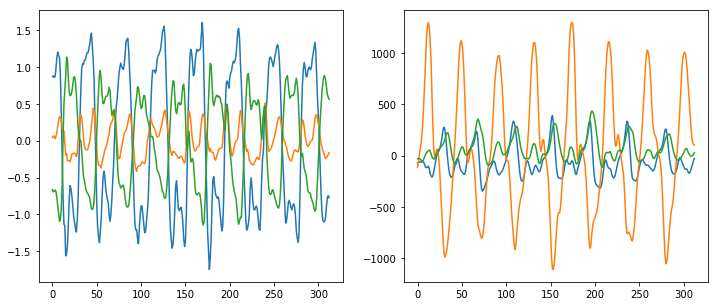

In [23]:
idx = np.random.choice(np.arange(len(dataP)),size=1)
d=dataN.iloc[int(idx)]
print(d)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(d.acc_xyz)
fig.add_subplot(122)
plt.plot(d.gyr_xyz)

In [107]:
# data['acclen']=data.apply()

In [24]:
#unpack clips, scores, subj and task data
le = LabelEncoder()
acc = data.acc_xyz.values
gyr = data.gyr_xyz.values
scores_brady = data.Bradykinesia
scores_tremor = data.Tremor
scores_dysk = data.Dyskinesia
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)

### Resample data

In [25]:
#check clips with less than 313 samples and resample
la=[]; lg=[]
for i in range(len(acc)):
    la.append(acc[i].shape[0])
    lg.append(gyr[i].shape[0])

print(np.unique(lg))

#resample all clips to 313 samples (62.5 Hz)
# accres = []
num = 313
accres = np.zeros((len(acc),num,3) )
gyrres = np.zeros((len(gyr),num,3) )
for i in range(len(acc)):
    if len(acc[i]<num):
        accres[i,:,0] = resample(acc[i][:,0],num)
        accres[i,:,1] = resample(acc[i][:,1],num)
        accres[i,:,2] = resample(acc[i][:,2],num)
    else: 
        accres[i,:,:] = acc[i].copy()
        
    if len(gyr[i]<num):
        gyrres[i,:,0] = resample(gyr[i][:,0],num)
        gyrres[i,:,1] = resample(gyr[i][:,1],num)
        gyrres[i,:,2] = resample(gyr[i][:,2],num)
    else:
        gyrres[i,:,:] = acc[i].copy()

[297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313]


In [26]:
acc = accres
gyr = gyrres

In [27]:
def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    x = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(x,axis=0)
    s = np.std(x,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(0,5):
            print(np.mean(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

In [28]:
accn = stdclipdata(acc,False)
gyrn = stdclipdata(gyr,False)

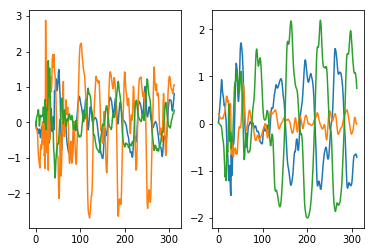

In [30]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(accn[0])
fig.add_subplot(122)
plt.plot(gyrn[0])

### Train CNN on bradykinesia data
* accelerometer only

In [31]:
# X = accn.copy()
X = np.concatenate((accn,gyrn),axis=-1) #use acc and gyro data
y = scores_brady.values
print(X.shape)
print(y.shape)

(27805, 313, 6)
(27805,)


In [32]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [33]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10])

In [34]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(26449, 313, 6)
(26449,)
(26449,)
(26449,)
(26449,)


In [35]:
#binarize labels
y[y>0] = 1

In [36]:
#load clips, standardize and split data into train and valid set
def prepare_data(X,y,network_type,balance=False):
    
    #standardize all data (note - should std training and apply on test)
#     Xn = stdclipdata(X)
#     Xn = X
    
    #perform a random train_valid split first to test approach
    inds = np.arange(0,len(y))
    X_train,X_valid,y_train,y_valid,inds_train,inds_valid = train_test_split(X,y,inds,test_size=0.2,stratify=task,random_state=32)
    print('X_train = ')
    print(X_train.shape)
    print('X_valid = ')
    print(X_valid.shape)
    
    #balance training dataset
    if balance:
        indsp = np.where(y_train==1)[0]
        indsn = np.random.choice(np.where(y_train==0)[0],size=round(1.5*len(indsp)),replace=False)
        inds = np.hstack((indsp,indsn))
        X_train=X_train[inds]
        y_train=y_train[inds]

    num_classes = 2 # 
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    
    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)
    print('X_train = ')
    print(X_train.shape)

    return X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim

In [121]:
X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim = prepare_data(X,y,'CNN')

X_train = 
(21159, 313, 6)
X_valid = 
(5290, 313, 6)
reshaping data for different models ...
CNN
X_train = 
(21159, 6, 313, 1)


In [122]:
#swap axes to have channel as last dim
X_train = np.swapaxes(X_train,1,3)
X_valid = np.swapaxes(X_valid,1,3)
print(X_train.shape)

(21159, 1, 313, 6)


In [123]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes =2 

In [124]:
print('building the model ...')
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(1, 6)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 313, 16)        3088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 78, 16)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 78, 16)         4112      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 13, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 208)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                6688      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)              

In [125]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/20
21159/21159 [==============================] - 14s - loss: 0.7126 - acc: 0.5068 - val_loss: 0.6869 - val_acc: 0.5694
Epoch 2/20
21159/21159 [==============================] - 14s - loss: 0.6801 - acc: 0.5605 - val_loss: 0.6577 - val_acc: 0.6284
Epoch 3/20
21159/21159 [==============================] - 14s - loss: 0.6463 - acc: 0.6243 - val_loss: 0.6088 - val_acc: 0.6631
Epoch 4/20
21159/21159 [==============================] - 15s - loss: 0.6128 - acc: 0.6653 - val_loss: 0.5815 - val_acc: 0.6951
Epoch 5/20
21159/21159 [==============================] - 17s - loss: 0.5870 - acc: 0.6911 - val_loss: 0.5641 - val_acc: 0.7042
Epoch 6/20
21159/21159 [==============================] - 15s - loss: 0.5646 - acc: 0.7136 - val_loss: 0.5371 - val_acc: 0.7187
Epoch 7/20
21159/21159 [==============================] - 13s - loss: 0.5385 - acc: 0.7368 - val_loss: 0.5191 - val_acc: 0.7357
Epoch 8/20
21159/21159 [============

In [126]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/20
21159/21159 [==============================] - 27s - loss: 0.4196 - acc: 0.8121 - val_loss: 0.4484 - val_acc: 0.7905
Epoch 2/20
21159/21159 [==============================] - 16s - loss: 0.3957 - acc: 0.8231 - val_loss: 0.4434 - val_acc: 0.7922
Epoch 3/20
21159/21159 [==============================] - 13s - loss: 0.3906 - acc: 0.8279 - val_loss: 0.4660 - val_acc: 0.7826
Epoch 4/20
21159/21159 [==============================] - 14s - loss: 0.3933 - acc: 0.8229 - val_loss: 0.4305 - val_acc: 0.8026
Epoch 5/20
21159/21159 [==============================] - 14s - loss: 0.3838 - acc: 0.8295 - val_loss: 0.4459 - val_acc: 0.7922
Epoch 6/20
21159/21159 [==============================] - 13s - loss: 0.3839 - acc: 0.8304 - val_loss: 0.4283 - val_acc: 0.8026
Epoch 7/20
21159/21159 [==============================] - 13s - loss: 0.3785 - acc: 0.8337 - val_loss: 0.4341 - val_acc: 0.7987
Epoch 8/20
21159/21159 [============

Unfitered

f1_test=0.811, Prec=0.784, Rec=0.839, auprc=0.900
[[1967  624]
 [ 434 2265]]
the mean f1 score:0.80


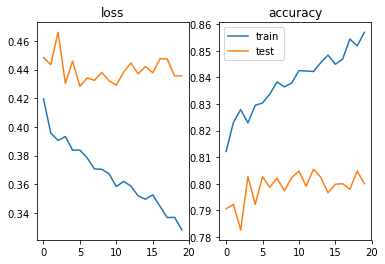

In [127]:
model_eval(X_valid,y_valid)

HP filtered data

f1_test=0.729, Prec=0.811, Rec=0.662, auprc=0.846
[[2173  418]
 [ 911 1788]]
the mean f1 score:0.75


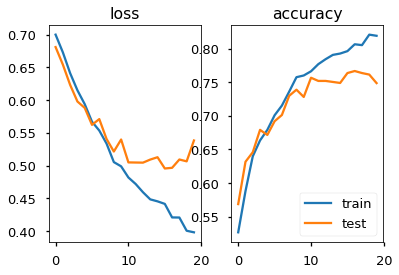

In [661]:
model_eval(X_valid,y_valid)

keep training

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/20
21159/21159 [==============================] - 7s - loss: 0.4250 - acc: 0.8030 - val_loss: 0.4631 - val_acc: 0.7811
Epoch 2/20
21159/21159 [==============================] - 7s - loss: 0.4036 - acc: 0.8145 - val_loss: 0.4652 - val_acc: 0.7784
Epoch 3/20
21159/21159 [==============================] - 7s - loss: 0.3991 - acc: 0.8138 - val_loss: 0.4816 - val_acc: 0.7715
Epoch 4/20
21159/21159 [==============================] - 7s - loss: 0.4012 - acc: 0.8128 - val_loss: 0.4740 - val_acc: 0.7792
Epoch 5/20
21159/21159 [==============================] - 7s - loss: 0.4048 - acc: 0.8125 - val_loss: 0.4813 - val_acc: 0.7733
Epoch 6/20
21159/21159 [==============================] - 7s - loss: 0.4010 - acc: 0.8173 - val_loss: 0.4697 - val_acc: 0.7767
Epoch 7/20
21159/21159 [==============================] - 7s - loss: 0.3956 - acc: 0.8160 - val_loss: 0.4750 - val_acc: 0.7762
Epoch 8/20
21159/21159 [===================

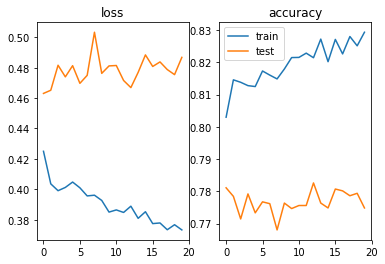

In [44]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))
model_eval(X_valid,y_valid)

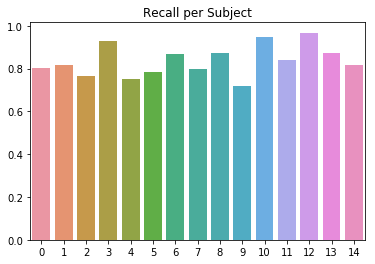

In [128]:
#recall rate per subject
y_pred = np.argmax(model.predict(X_valid),axis=1)
y_valid = np.argmax(y_valid,axis=1)
subj_valid=subj[inds_valid]

RecS = []
for s in np.unique(subj_valid):

    indS = np.where(subj_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.arange(len(RecS)),y=RecS)
plt.title('Recall per Subject')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

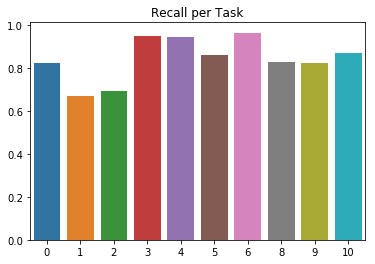

In [129]:
#recall rate per task
y_pred = np.argmax(model.predict(X_valid),axis=1)
# y_valid = np.argmax(y_valid,axis=1)
task_valid=task[inds_valid]

RecS = []
for s in np.unique(task_valid):

    indS = np.where(task_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.unique(task_valid),y=RecS)
plt.title('Recall per Task')
plt.xticks()

In [61]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

In [62]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


In [63]:
indscorrect=inds_valid[y_valid==y_pred]
indswrong=inds_valid[y_valid!=y_pred]

In [64]:
len(indswrong)

1220

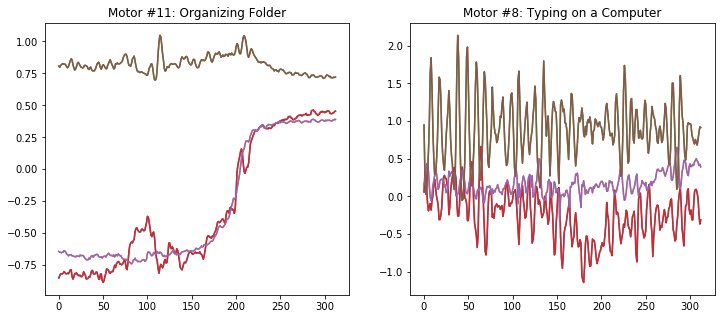

In [69]:
tasklist=(list(zip(taskcodes,tasknames)))
idx1 = np.random.choice(indswrong,size=1)
idx2 = np.random.choice(indscorrect,size=1)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(X[idx1][0])
plt.title(tasklist[int(task[idx1])][1])
fig.add_subplot(122)
plt.plot(X[idx2][0])
plt.title(tasklist[int(task[idx2])][1])

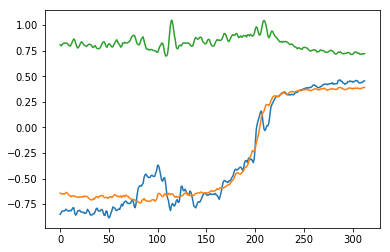

In [78]:
plt.plot(X[idx1][0][:,0:3])

## Train on Tremor

In [469]:
X = accn.copy()
y = scores_tremor.values
print(X.shape)
print(y.shape)

(27805, 313, 3)
(27805,)


In [474]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [476]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [477]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(27532, 313, 3)
(27532,)
(27532,)
(27532,)
(27532,)


In [478]:
#binarize labels
y[y>0] = 1

In [479]:
sum(y>0)/len(y)

0.22784396338805754

In [480]:
#load clips, standardize and split data into train and valid set
def prepare_data(X,y,network_type,balance=False):
    
    #standardize all data (note - should std training and apply on test)
#     Xn = stdclipdata(X)
#     Xn = X
    
    #perform a random train_valid split first to test approach
    inds = np.arange(0,len(y))
    X_train,X_valid,y_train,y_valid,inds_train,inds_valid = train_test_split(X,y,inds,test_size=0.2,stratify=task,random_state=32)
    print('X_train = ')
    print(X_train.shape)
    print('X_valid = ')
    print(X_valid.shape)
    
    #balance training dataset
    if balance:
        indsp = np.where(y_train==1)[0]
        indsn = np.random.choice(np.where(y_train==0)[0],size=round(1.5*len(indsp)),replace=False)
        inds = np.hstack((indsp,indsn))
        X_train=X_train[inds]
        y_train=y_train[inds]

    num_classes = 2 # 
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    
    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)
    print('X_train = ')
    print(X_train.shape)

    return X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim

In [481]:
X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim = prepare_data(X,y,'CNN')

X_train = 
(22025, 313, 3)
X_valid = 
(5507, 313, 3)
reshaping data for different models ...
CNN
X_train = 
(22025, 3, 313, 1)


In [482]:
#swap axes to have channel as last dim
X_train = np.swapaxes(X_train,1,3)
X_valid = np.swapaxes(X_valid,1,3)
print(X_train.shape)

(22025, 1, 313, 3)


In [483]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes =2 

In [484]:
print('building the model ...')
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(1, 6)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 313, 16)        1552      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 78, 16)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 78, 16)         4112      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 13, 16)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 208)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                6688      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)              

In [485]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 22025 samples, validate on 5507 samples
Epoch 1/20
22025/22025 [==============================] - 7s - loss: 0.5758 - acc: 0.7578 - val_loss: 0.4713 - val_acc: 0.7707
Epoch 2/20
22025/22025 [==============================] - 7s - loss: 0.4756 - acc: 0.7763 - val_loss: 0.4499 - val_acc: 0.7777
Epoch 3/20
22025/22025 [==============================] - 7s - loss: 0.4524 - acc: 0.7878 - val_loss: 0.4255 - val_acc: 0.8073
Epoch 4/20
22025/22025 [==============================] - 8s - loss: 0.4305 - acc: 0.8021 - val_loss: 0.4140 - val_acc: 0.8124
Epoch 5/20
22025/22025 [==============================] - 9s - loss: 0.4173 - acc: 0.8130 - val_loss: 0.4165 - val_acc: 0.8157
Epoch 6/20
22025/22025 [==============================] - 10s - loss: 0.4104 - acc: 0.8204 - val_loss: 0.3959 - val_acc: 0.8233
Epoch 7/20
22025/22025 [==============================] - 9s - loss: 0.3972 - acc: 0.8294 - val_loss: 0.3886 - val_acc: 0.8282
Epoch 8/20
22025/22025 [==================

f1_test=0.588, Prec=0.724, Rec=0.495, auprc=0.689
[[4004  239]
 [ 638  626]]
the mean f1 score:0.74


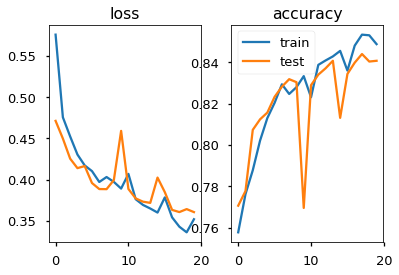

In [508]:
model_eval(X_valid,y_valid)

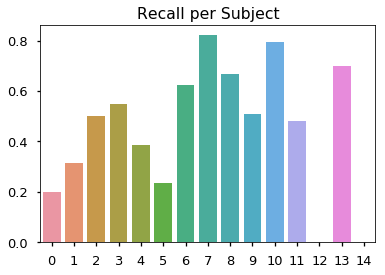

In [545]:
#recall rate per subject
y_pred = np.argmax(model.predict(X_valid),axis=1)
subj_valid=subj[inds_valid]

RecS = []
for s in np.unique(subj_valid):

    indS = np.where(subj_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.arange(len(RecS)),y=RecS)
plt.title('Recall per Subject')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

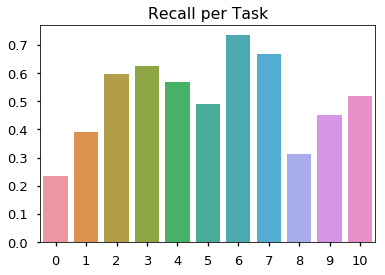

In [523]:
#recall rate per task
y_pred = np.argmax(model.predict(X_valid),axis=1)
y_valid = np.argmax(y_valid,axis=1)
task_valid=task[inds_valid]

RecS = []
for s in np.unique(task_valid):

    indS = np.where(task_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.unique(task_valid),y=RecS)
plt.title('Recall per Task')
plt.xticks()

In [60]:
tasklist=(list(zip(taskcodes,tasknames)))

NameError: name 'taskcodes' is not defined

In [639]:
print(tasklist)

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


In [539]:
indscorrect=inds_valid[y_valid==y_pred]
indswrong=inds_valid[y_valid!=y_pred]

In [543]:
len(indswrong)

877

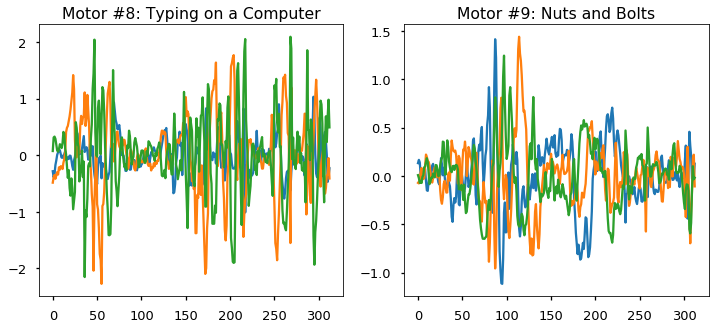

In [640]:
idx1 = np.random.choice(indswrong,size=1)
idx2 = np.random.choice(indscorrect,size=1)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(X[idx1][0])
plt.title(tasklist[int(task[idx1])][1])
fig.add_subplot(122)
plt.plot(X[idx2][0])
plt.title(tasklist[int(task[idx2])][1])

** One problem is that we do not know where the symptom shows in the entire recording**

## Train on entire recordings

In [11]:
Data = pd.read_csv('../FeatureMatrix/DataFullRec.csv')
Data.head(3)

,Unnamed: 0,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.002610,0.003850,0.002191,...,0.000877,1.680997,2.118982,0.000010,0.028629,-0.256309,8.984299,0.676526,0.625630,0.630607
1,0,1004,2 Weeks: Time 30,Motor #2: Walking,dorsal_hand_left,0.0,0.0,0.003935,0.004898,0.003074,...,0.001397,0.962419,-0.373278,-0.000018,0.041619,-0.352026,12.063202,0.654396,0.694583,0.616817
2,0,1004,2 Weeks: Time 60,Motor #2: Walking,dorsal_hand_left,0.0,0.0,0.005156,0.007520,0.003912,...,0.004366,1.755201,3.318823,0.000038,0.046787,-0.069417,6.359663,0.570756,0.630046,0.575315


In [16]:
len(Data)

2376

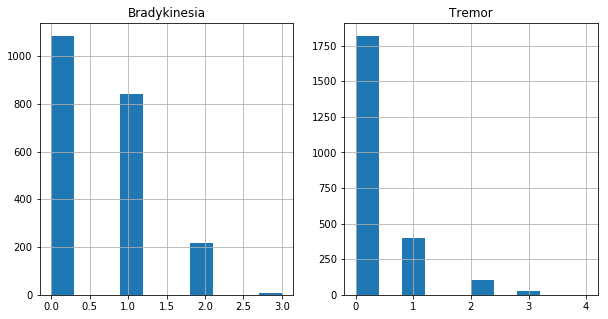

In [12]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

In [13]:
symptom = 'Bradykinesia'
indp = ((Data[symptom]>0))

In [15]:
#LOSO CV
groups = Data.Subject.as_matrix()

In [27]:
groups

array([1004, 1004, 1004, ..., 1051, 1051, 1051])

In [20]:
#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)
print(X_std.shape)

(2376, 37)


In [25]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0)) #binarize
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    LOSOCV(Data,X_std,y,groups,models)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 529/2376 = 0.22
Training Random Forest

Subj 0, prec=0.167, rec=0.118

Subj 1, prec=0.667, rec=0.048

Subj 2, prec=0.857, rec=0.214

Subj 3, prec=0.360, rec=0.692

Subj 4, prec=0.333, rec=0.200

Subj 5, prec=0.250, rec=0.048

Subj 6, prec=0.594, rec=0.275

Subj 7, prec=0.824, rec=0.538

Subj 8, prec=0.400, rec=0.087

Subj 9, prec=0.926, rec=0.231

Subj 10, prec=0.842, rec=0.842

Subj 11, prec=0.200, rec=0.045

Subj 12, prec=0.000, rec=0.000

Subj 13, prec=0.794, rec=0.380

Subj 14, prec=0.000, rec=0.000
f1_test=0.290+/-0.242, prec=0.481+/-0.313, rec=0.248+/-0.251, auprc=0.469+/-0.283
Training XGB

Subj 0, prec=0.176, rec=0.176

Subj 1, prec=0.714, rec=0.060

Subj 2, prec=0.667, rec=0.214

Subj 3, prec=0.296, rec=0.615

Subj 4, prec=0.333, rec=0.200

Subj 5, prec=0.250, rec=0.095

Subj 6, prec=0.553, rec=0.304

Subj 7, prec=0.846, rec=0.423

Subj 8, prec=0.500, rec=0.217

Subj 9, prec=0.923, rec=0.222

Subj 10, prec=0.667, rec=0.632

Subj 11, prec=0.143, rec=0.045

Subj 12

In [36]:
scores = []
for s in Data.Subject.unique():
    scores.append(Data.loc[Data['Subject']==s,'Bradykinesia'].max())

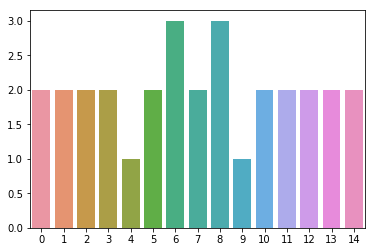

In [37]:
sns.barplot(x=np.arange(len(Data.Subject.unique())),y=scores)

In [47]:
for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]
    model_name = ['Random Forest']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 529/2376 = 0.22
Random Forest
f1_train=1.000+/-0.000, f1_test=0.550+/-0.056, prec=0.826+/-0.084, rec=0.414+/-0.050, auprc=0.733+/-0.067
[[359  10]
 [ 60  45]]
Rows w Bradykinesia 1068/2376 = 0.45
Random Forest
f1_train=1.000+/-0.000, f1_test=0.755+/-0.015, prec=0.777+/-0.006, rec=0.735+/-0.026, auprc=0.837+/-0.017
[[216  45]
 [ 60 153]]
Elapsed time = 9152.000


## Feature importance

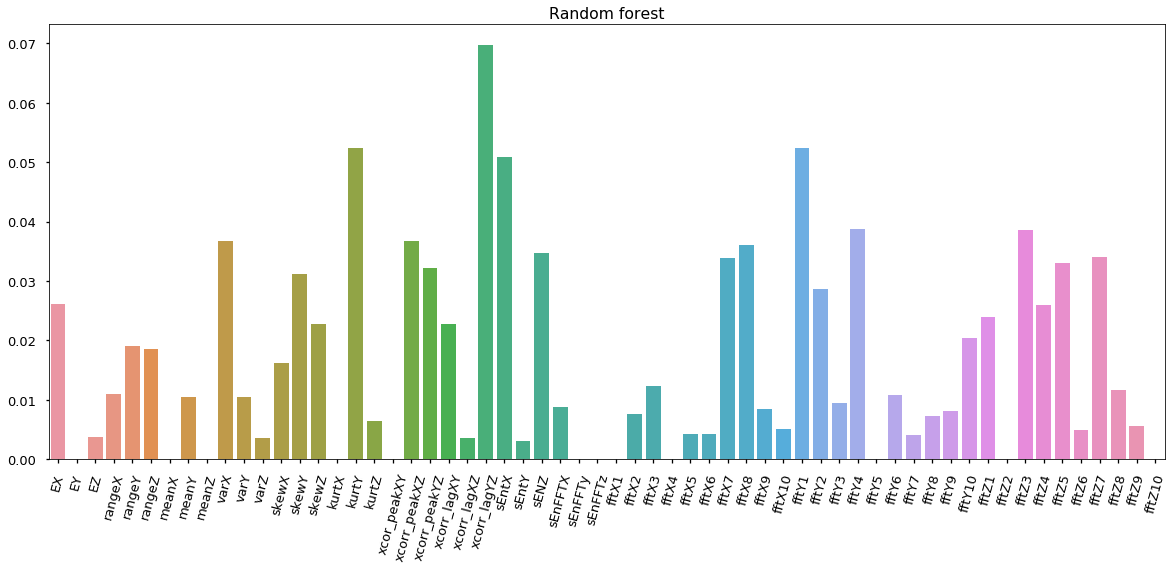

In [181]:
clf = models[1][0]
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('Random forest')